# Techniken in MachineLearning - NLP (Natural Language Processing)

Datensatz [Amazon Commerce reviews set Data Set](https://archive.ics.uci.edu/ml/datasets/Amazon+Commerce+reviews+set)

In [1]:
!pip install nltk
!pip install seaborn

In [2]:
import re
import nltk
import scipy
import pandas
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from typing import List, Dict, Union
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bogdi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bogdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Amazon Fine Foods Reviews
##### Quelle:
J. McAuley und J. Leskovec. Von Amateuren zu Kennern: Gestaltung der Entwicklung von Nutzerkompetenz durch Online-Bewertungen. WWW, 2013.

##### Informationsdatensatz:
Dieser Datensatz besteht aus Rezensionen von Feinkostprodukten auf Amazon. Die Daten erstrecken sich über mehr als 10 Jahre, einschließlich aller ~500.000 Rezensionen bis Oktober 2012. Die Rezensionen enthalten Produkt- und Benutzerinformationen, Bewertungen und eine reine Textrezension. Wir haben auch Rezensionen aus allen anderen Amazon-Kategorien.

##### Informationen zu den Attributen:
Anzahl der Rezensionen: 568,454 <br>
Anzahl der Nutzer: 256.059 <br>
Anzahl der Produkte: 74,258 <br>
Nutzer mit > 50 Bewertungen: 260 <br>
Mittlere Anzahl von Wörtern pro Bewertung: 56 <br>
Dauer des Zeitraums: Oktober 1999 - Oktober 2012 <br>

In [3]:
df:object = pd.read_csv('./Reviews.csv', index_col=0)
df = df.dropna()
print(f'Die Form des Datenrahmens ist: {df.shape}')
df.head(5)

Die Form des Datenrahmens ist: (568411, 9)


,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, inplace=True)
print(f'Der Datenrahmen hat nach dem Entfernen der doppelten Zeilen folgende Form: {df.shape}')

Der Datenrahmen hat nach dem Entfernen der doppelten Zeilen folgende Form: (393919, 9)


Grafik, die zeigt, welche Kundenrezensionen die Mehrheit sind. <br>
Es ist zu erkennen, dass die Bewertungen mit der höchsten Punktzahl (ca. 250000) überwiegen. <br>
Wir können die Bewertungen entsprechend ihrer Punktzahl wie folgt in Kategorien einteilen: <br>
Punktzahl > 3 -> positive Bewertung <br>
Punktzahl = 3 -> neutrale Bewertung <br>
Punktzahl < 3 -> negative Bewertung <br>
Auch hier überwiegen die positiven Bewertungen (ca. 310000), aber auch die negativen Bewertungen sind nicht zu vernachlässigen (ca. 70000).

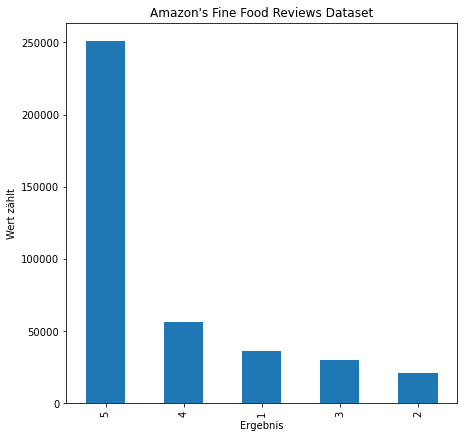

In [5]:
ax:object = df['Score'].value_counts().plot(kind='bar', figsize=(7,7))
fig:object = ax.get_figure()
ax.set_title("Amazon's Fine Food Reviews Dataset")
ax.set_xlabel('Ergebnis')
ax.set_ylabel('Wert zählt');

In [6]:
print('Eine knappe Zusammenfassung des DataFrame ist:')
df.info()

Eine knappe Zusammenfassung des DataFrame ist:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 393919 entries, 1 to 568454
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               393919 non-null  object
 1   UserId                  393919 non-null  object
 2   ProfileName             393919 non-null  object
 3   HelpfulnessNumerator    393919 non-null  int64 
 4   HelpfulnessDenominator  393919 non-null  int64 
 5   Score                   393919 non-null  int64 
 6   Time                    393919 non-null  int64 
 7   Summary                 393919 non-null  object
 8   Text                    393919 non-null  object
dtypes: int64(4), object(5)
memory usage: 30.1+ MB


Wir wollen weitere Informationen über die Bewertungen erfahren, wie z. B.: <br>
Längste, kürzeste Bewertung <br>
Längste, kürzeste Zusammenfassung <br>
Die Person mit den meisten Bewertungen <br>
Diese Daten helfen uns, einen besseren Überblick über den Datensatz zu bekommen, mit dem wir arbeiten.

In [7]:
print(f'Die längste geschriebene Rezension ist: {df.Text.map(lambda x: len(x)).max()}')
print(f'Die kürzeste geschriebene Rezension ist: {df.Text.map(lambda x: len(x)).min()}')
print(f'Die längste Zusammenfassung lautet: {df.Summary.map(lambda x: len(x)).max()}')
print(f'Die kürzeste Zusammenfassung lautet: {df.Summary.map(lambda x: len(x)).min()}')
print(f'Der Name des Profils mit den meisten Bewertungen lautet:')
print(df.ProfileName.mode())

Die längste geschriebene Rezension ist: 21409
Die kürzeste geschriebene Rezension ist: 12
Die längste Zusammenfassung lautet: 128
Die kürzeste Zusammenfassung lautet: 1
Der Name des Profils mit den meisten Bewertungen lautet:
0    Gary Peterson
dtype: object


In [8]:
contractions:Dict[str,str] = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [9]:
def clean_text(text:str, remove_stopwords:bool = True) -> str:
    """
    Unerwünschte Zeichen und Stoppwörter entfernen und den Text so formatieren, dass weniger Nullen in den Text eingebettet werden
    param text: der Text, der formatiert werden soll
    param remove_stopwords: 
    Rückgabe:
    """
    
    # Konvertiert Wörter so, dass sie nur kleine Buchstaben haben.
    text = text.lower()
    
    # Ersetzt Abkürzungen durch ihre Langform
    if True:
        text = text.split()
        new_text:List[str] = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Wörter formatieren und unerwünschte Zeichen wie Anführungszeichen, Punkte usw. entfernen.
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # Unnötige Wörter entfernen
    if remove_stopwords:
        text = text.split()
        stops:set = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenisierung des Textes: Sätze in Wörter unterteilen
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [10]:
df['Text_Cleaned'] = list(map(clean_text, df.Text))
def lemmatized_words(text):
    lemm:nltk.stem.wordnet.WordNetLemmatizer = nltk.stem.WordNetLemmatizer()
    df['Lemmatized_text'] = list(map(lambda word:list(map(lemm.lemmatize, word)),df.Text_Cleaned))

lemmatized_words(df.Text_Cleaned)

In [11]:
df.head(5)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Text_Cleaned,Lemmatized_text
Id,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[bought, several, vitality, canned, dog, food,...","[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[product, arrived, labeled, jumbo, salted, pea...","[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy...","[confection, around, century, light, pillowy, ..."
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli...","[looking, secret, ingredient, robitussin, beli..."
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"[great, taffy, great, price, wide, assortment,...","[great, taffy, great, price, wide, assortment,..."


In [12]:
pd.set_option('max_colwidth', 500)
df[['Score', 'Text', 'Text_Cleaned', 'Lemmatized_text']].sample(5)

,Score,Text,Text_Cleaned,Lemmatized_text
Id,,,,
178880,4,"I use this stuff all the time in coffee, tea, and baking. There a bit of an aftertaste, but it's not as bitter as Stevia and I only really notice it when I use it make something like maple syrup. I'm also not convinced that the conversion is 2 drops = 2 tsp. I think you need a little more than two drops, but you're still getting a ton of sweetener in a tiny bottle. Overall, I'm pretty happy with it.","[use, stuff, time, coffee, tea, baking, bit, aftertaste, bitter, stevia, really, notice, use, make, something, like, maple, syrup, also, convinced, conversion, 2, drops, 2, tsp, think, need, little, two, drops, still, getting, ton, sweetener, tiny, bottle, overall, pretty, happy]","[use, stuff, time, coffee, tea, baking, bit, aftertaste, bitter, stevia, really, notice, use, make, something, like, maple, syrup, also, convinced, conversion, 2, drop, 2, tsp, think, need, little, two, drop, still, getting, ton, sweetener, tiny, bottle, overall, pretty, happy]"
296295,5,"I put this **** on everything. Well all meats that I grill/smoke anyway. I first ran into this product while living in Austin, TX over 10 years ago and have been using it since. For whatever reason I decided to check Amazon as I usually order directly from Bolner's site. What do you know? It's not only on Amazon, but it is a Prime eligible product as well. For anyone who may read this review, buy the smaller container of this stuff to give it a try if you are not 100% sure, and I bet that...","[put, everything, well, meats, grill, smoke, anyway, first, ran, product, living, austin, tx, 10, years, ago, using, since, whatever, reason, decided, check, amazon, usually, order, directly, bolner, site, know, amazon, prime, eligible, product, well, anyone, may, read, review, buy, smaller, container, stuff, give, try, 100, sure, bet, next, order, buy, big, container]","[put, everything, well, meat, grill, smoke, anyway, first, ran, product, living, austin, tx, 10, year, ago, using, since, whatever, reason, decided, check, amazon, usually, order, directly, bolner, site, know, amazon, prime, eligible, product, well, anyone, may, read, review, buy, smaller, container, stuff, give, try, 100, sure, bet, next, order, buy, big, container]"
173021,4,"I've tried all of the Maesri curries and haven't found one that I don't like. They really can't be beat for convenience, price, and taste. But be warned, this one is HOT! (It made my girlfriend cry) If you don't like the spice, either add some coconut milk or try a different one all together.","[tried, maesri, curries, found, one, like, really, cannot, beat, convenience, price, taste, warned, one, hot, made, girlfriend, cry, like, spice, either, add, coconut, milk, try, different, one, together]","[tried, maesri, curry, found, one, like, really, cannot, beat, convenience, price, taste, warned, one, hot, made, girlfriend, cry, like, spice, either, add, coconut, milk, try, different, one, together]"
246225,5,It's really stronge but if you combine it with the right foods it taste excellent.. Don't laugh I've found it taste very good with rice..,"[really, stronge, combine, right, foods, taste, excellent, laugh, found, taste, good, rice]","[really, stronge, combine, right, food, taste, excellent, laugh, found, taste, good, rice]"
15385,5,As a young girl this was one of my favorite treats! As the years passed it became unavailable. I am so glad I was able to find it here on Amazon. My family and I can once again enjoy the great taste of Tahitian Treat!!!,"[young, girl, one, favorite, treats, years, passed, became, unavailable, glad, able, find, amazon, family, enjoy, great, taste, tahitian, treat]","[young, girl, one, favorite, treat, year, passed, became, unavailable, glad, able, find, amazon, family, enjoy, great, taste, tahitian, treat]"


In [13]:
bow_converter:sklearn.feature_extraction.text.CountVectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False)
x:scipy.sparse.csr.csr_matrix = bow_converter.fit_transform(df['Text_Cleaned'])

words:List[str] = bow_converter.get_feature_names()
print(f'Der bereinigte Text hat: {len(words)} Wörter')

Der bereinigte Text hat: 110422 Wörter


In [14]:
bow:sklearn.feature_extraction.text.CountVectorizer = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False)
X1:scipy.sparse.csr.csr_matrix = bow.fit_transform(df['Text_Cleaned'])
y1:np.ndarray = df['Score']
    
X1 = X1[:1000]
y1 = y1[:1000]

In [15]:
linear_reg:sklearn.linear_model._base.LinearRegression = LinearRegression()
ridge:sklearn.linear_model._ridge.Ridge = Ridge(alpha=1.0)
lasso:sklearn.linear_model._coordinate_descent.Lasso = Lasso(alpha=1.0)
elastic_net:sklearn.linear_model._coordinate_descent.ElasticNet = ElasticNet(random_state=0)

linear_reg.fit(X1, y1)
ridge.fit(X1, y1)
lasso.fit(X1, y1)
elastic_net.fit(X1, y1)

ElasticNet(random_state=0)

In [ ]:
ridge:sklearn.linear_model._ridge.Ridge = Ridge(alpha=1.0)
lasso:sklearn.linear_model._coordinate_descent.Lasso = Lasso(alpha=1.0)
elastic_net:sklearn.linear_model._coordinate_descent.ElasticNet = ElasticNet(random_state=0)

ridge.fit(X1, y1)
lasso.fit(X1, y1)
elastic_net.fit(X1, y1)

In [16]:
def lin_reg_params() -> Dict[str,List[bool]]:
    """
    Erzeugt ein Wörterbuch mit den Namen der Parameter als Schlüssel und als Werte,
    Listen mit den möglichen Werten; für lineare Regression
    return: das Wörterbuch
    """
    copy_X:List[bool] = [True,False]
    fit_intercept:List[bool] = [True,False]
    return dict(copy_X=copy_X, fit_intercept=fit_intercept)

def lasso_ridge_elastic_params() -> Dict[str,List[Union[float,bool]]]:
    """
    Erzeugt ein Wörterbuch mit den Namen der Parameter als Schlüssel und als Werte,
    Listen mit den möglichen Werten; für Lasso, Ridge und Elastic Net
    return: das Wörterbuch
    """
    alpha:List[float] = [1.0,1.1,1.2,1.3,1.4,1.5]
    fit_intercept:List[bool] = [True,False]
    return dict(alpha=alpha, fit_intercept=fit_intercept)

def randomized_search(model:sklearn.linear_model, param_distributions:Dict[str,List[Union[float,bool]]], data:np.ndarray, target:np.ndarray) -> float:
    """
    Berechnet die optimalen Hyperparameterwerte für ein gewähltes Regressionsmodell für einen gegebenen Datensatz
    param model: das Regressionsmodell
    param param_distributions: Wörterbuch mit den Namen der Parameter als Wert der Schlüssel und einer Reihe von Werten
    param date: das Datum des Datensatzes
    param target: das Ziel des Datensatzes
    """
    randomized_src:sklearn.model_selection.RandomizedSearchCV = RandomizedSearchCV(estimator = model, param_distributions=param_distributions, n_iter = 5, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    randomized_src.fit(data, target)
    return randomized_src

def randomize_calculate(model:sklearn.linear_model, params:Dict[str,List[Union[float,bool]]], data:np.ndarray, target:np.ndarray, score_type:str, error_type:str) -> float:
    """
    Meldet die mittleren Ergebnisse für eine der Fold-Links (train / test) mit RandomizedSearchCV
    param model: das Regressionsmodell
    param param_grid: Wörterbuch mit dem Namen der Parameter als Wert der Schlüssel und einer Reihe von Werten
    param date: die Daten des Datensatzes
    param target: das Ziel des Datensatzes
    param score_type: der Typ der Punktzahl
    param error_type: die Art des Fehlers
    """
    rand_src:sklearn.model_selection.RandomizedSearchCV = randomized_search(model, params, data, target)
    result:List[float] = cross_validate(rand_src, data, target, cv=5, return_train_score=True, scoring=error_type)
    return result[score_type].mean()

def get_errors_score(score_type: str, error_type: str, data:np.ndarray, target:np.ndarray) -> List[float]:
    """
    Erstellt eine Liste aus den mittleren Ergebnissen für die Trainingsfalten sowie für die Testfalten,
    für einen gegebenen Datensatz
    param score_type: die Art des Ergebnisses
    param error_type: Typ des Fehlers
    param date: das Datum des Datensatzes
    param target: das Ziel des Datensatzes
    return: Liste der Durchschnittswerte
    """
    column:List[float] = []
    column.append(randomize_calculate(linear_reg, lin_reg_params(), data, target, score_type, error_type))
    column.append(randomize_calculate(ridge, lasso_ridge_elastic_params(), data, target, score_type, error_type))  
    column.append(randomize_calculate(lasso, lasso_ridge_elastic_params(), data, target, score_type, error_type))   
    column.append(randomize_calculate(elastic_net, lasso_ridge_elastic_params(), data, target, score_type, error_type))   
    return column

def get_data_frame(data:np.ndarray, target:np.ndarray) -> Dict[str,List[Union[str,float]]]:
    """
    Erzeugt ein Wörterbuch aus den Spalten der Ergebnisdurchschnitte für die Trainingsfalten,
    sowie für die Testfalten, für einen bestimmten Datensatz
    param date: die Daten des Datensatzes
    param target: das Ziel des Datensatzes
    return: das Wörterbuch
    """
    test_neg_mean_absolute_error:List[float] = get_errors_score('test_score', 'neg_mean_absolute_error', data, target)    
    test_neg_mean_squared_error:List[float] = get_errors_score('test_score', 'neg_mean_squared_error', data, target)
    test_r2_error:List[float] = get_errors_score('test_score', 'r2', data, target)
    train_neg_mean_absolute_error:List[float] = get_errors_score('train_score', 'neg_mean_absolute_error', data, target)
    train_neg_mean_squared_error:List[float] = get_errors_score('train_score', 'neg_mean_squared_error', data, target)
    train_r2_error:List[float] = get_errors_score('train_score', 'r2', data, target)

    data_frame:Dict[str,List[Union[str,float]]] = {
            'Model_name': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net'],
            'Search_strategy': ['RandomizedSearchCV', 'RandomizedSearchCV', 'RandomizedSearchCV','RandomizedSearchCV'],
            'test_neg_mean_absolute_error': test_neg_mean_absolute_error,
            'test_neg_mean_squared_error': test_neg_mean_squared_error,
            'test_r2_error': test_r2_error,
            'train_neg_mean_absolute_error': train_neg_mean_absolute_error,
            'train_neg_mean_squared_error': train_neg_mean_squared_error,
            'train_r2_error': train_r2_error,
        }
    return data_frame

def get_positive_data_frame(data_frame: Dict[str,List[Union[str,float]]]) -> Dict[str,List[Union[str,float]]]:
    """
    Erstellt ein Wörterbuch mit positiven Werten aus den Spalten, die sich aus den Durchschnittswerten der Ergebnisse
    sowohl für die Trainings- als auch für die Testfalten für einen bestimmten Datensatz
    param date: die Daten des Datensatzes
    param target: das Ziel des Datensatzes
    return: das Wörterbuch
    """
    pos_data_frame:Dict[str,List[Union[str,float]]] = {}
    lst:List[Union[str,float]] = []
    for key in data_frame:
        for value in data_frame[key]:
            if isinstance(value, float):
                lst.append(abs(value))
            else:
                lst.append(value)
        pos_data_frame[key.replace("_neg","")] = lst
        lst = []
    return pos_data_frame

In [17]:
data_frame:Dict[str,List[Union[str,float]]] = get_data_frame(X1, y1)
new_data_frame:pandas.core.frame.DataFrame = pd.DataFrame(data_frame)
display(new_data_frame)

,Model_name,Search_strategy,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2_error,train_neg_mean_absolute_error,train_neg_mean_squared_error,train_r2_error
0,Linear Regression,RandomizedSearchCV,-1.345795,-3.650591,-1.135267,-0.000002,-6.455055e-12,1.000000
1,Ridge,RandomizedSearchCV,-1.084225,-2.095031,-0.210580,-0.106435,-2.502891e-02,0.985062
2,Lasso,RandomizedSearchCV,-1.055418,-1.761159,-0.010801,-1.053401,-1.753556e+00,0.000000
3,Elastic Net,RandomizedSearchCV,-1.055418,-1.761159,-0.010801,-1.053401,-1.753556e+00,0.000000


In [18]:
positive_data_frame:Dict[str,List[Union[str,float]]] = get_positive_data_frame(data_frame)
pos_df:pandas.core.frame.DataFrame = pd.DataFrame(positive_data_frame)
display(pos_df)

,Model_name,Search_strategy,test_mean_absolute_error,test_mean_squared_error,test_r2_error,train_mean_absolute_error,train_mean_squared_error,train_r2_error
0,Linear Regression,RandomizedSearchCV,1.345795,3.650591,1.135267,0.000002,6.455055e-12,1.000000
1,Ridge,RandomizedSearchCV,1.084225,2.095031,0.210580,0.106435,2.502891e-02,0.985062
2,Lasso,RandomizedSearchCV,1.055418,1.761159,0.010801,1.053401,1.753556e+00,0.000000
3,Elastic Net,RandomizedSearchCV,1.055418,1.761159,0.010801,1.053401,1.753556e+00,0.000000


In [19]:
style:pandas.io.formats.style.Styler = pos_df.style.\
    highlight_max(color = 'green', axis = 0).\
    highlight_min(color = 'red', axis = 0)

style

,Model_name,Search_strategy,test_mean_absolute_error,test_mean_squared_error,test_r2_error,train_mean_absolute_error,train_mean_squared_error,train_r2_error
0,Linear Regression,RandomizedSearchCV,1.345795,3.650591,1.135267,0.000002,0.000000,1.000000
1,Ridge,RandomizedSearchCV,1.084225,2.095031,0.210580,0.106435,0.025029,0.985062
2,Lasso,RandomizedSearchCV,1.055418,1.761159,0.010801,1.053401,1.753556,0.000000
3,Elastic Net,RandomizedSearchCV,1.055418,1.761159,0.010801,1.053401,1.753556,0.000000
